# Single member analyses of models with future scenarios

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import LSQUnivariateSpline

datapath = '../Processed_data/Nino3_4_monthly/'
experiments = ['piControl', 'historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
models = ['BCC-CSM2-MR', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'MIROC-ES2L', 
          'MIROC6', 'UKESM1-0-LL', 'MRI-ESM2-0',  'CESM2', 'CESM2-WACCM', 'MCM-UA-1-0']

# create dictionary of data for each model, containing only the member we want to use:
data_dict = {}
for model in models:
    data_dict[model] = {}
    
    file = datapath + model + '_nino3_4monthlyindex.txt'
    data_table = pd.read_csv(file, index_col=0, header=[0,1], keep_default_na = False)
    if model in ['BCC-CSM2-MR', 'CanESM5', 'MIROC6', 'MRI-ESM2-0',  'CESM2', 'CESM2-WACCM']:
        for exp in experiments:
            member = 'r1i1p1f1'
            data_list = data_table[exp][member].values
            data_dict[model][exp] = np.array([np.float(i) for i in data_list if i])
    elif model in ['MIROC-ES2L', 'CNRM-CM6-1','MCM-UA-1-0', 'UKESM1-0-LL']:
        for exp in experiments:
            if exp == 'piControl' and model == 'MCM-UA-1-0':
                member = 'r1i1p1f1'
            else:
                member = 'r1i1p1f2' # I have checked that historical f2 branches from piControl f1 in MCM-UA-1-0.
            if exp in data_table: # additional if-test here, since 'MCM-UA-1-0' is missing the 'ssp126' experiment
                data_list = data_table[exp][member].values
                data_dict[model][exp] = np.array([np.float(i) for i in data_list if i])         
    elif model in ['CNRM-ESM2-1']:
        for exp in experiments:
            if exp == 'piControl':
                member = 'r1i1p1f2'
            else: 
                member = 'r2i1p1f2' # I have checked that historical r2 branches from piControl r1.
            data_list = data_table[exp][member].values
            data_dict[model][exp] = np.array([np.float(i) for i in data_list if i])  
# We know from testing in Figure 1 that all time series for these members are long enough (no missing years)

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Choose a model

In [2]:
model = models[1]
model

'CanESM5'

ssp126
ssp245
ssp370
ssp585


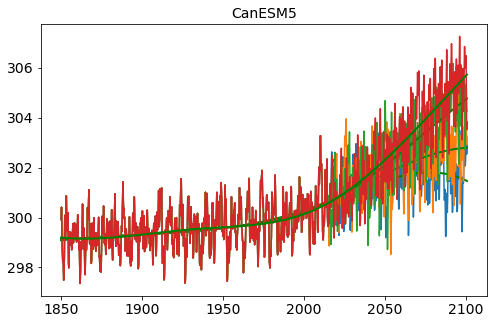

In [3]:
fig, ax = plt.subplots(figsize = [8,5])

internal_knots = [1850 + (2014-1850)/2, 2014] # = historical midpoint (1932) and endpoint (2014)

hist_years = np.arange(1850 + 0.5/12 + 1/12, 2015-1/12, 1/12)
ssp_years = np.arange(2015+ 0.5/12, 2101-1/12, 1/12)
all_years = np.arange(1850 + 0.5/12 + 1/12, 2101-1/12, 1/12)
ssp_length = 86*12-1; # cut in year 2100. Some exp go beyond this year.

hist_data = data_dict[model]['historical']
hist_trends = {}

# combine historical and ssp data, then smooth the combined time series
# to minimize discontinuity of the trend between years 2014 - 2015
for exp in data_dict[model].keys():
    if exp not in ['piControl', 'historical']:
        print(exp)
        ssp_data = data_dict[model][exp][:ssp_length]
        # approximate missing end of historical by a mean
        exp_data = np.concatenate((hist_data, [np.mean([hist_data[-1], ssp_data[0]])], ssp_data))
        plt.plot(all_years, exp_data) 
        spl = LSQUnivariateSpline(all_years, exp_data, internal_knots)
        ax.plot(all_years, spl(all_years), 'g', lw=2)

ax.set_title(model, fontsize = 14)
ax.tick_params(axis='both',labelsize=14)   
#ax.set_xlim(2000, 2020)
#ax.set_ylim(299, 301)

## Loop through all models and create dictionary of anomaly data:

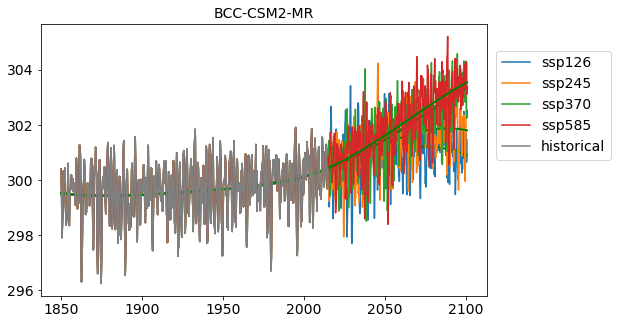

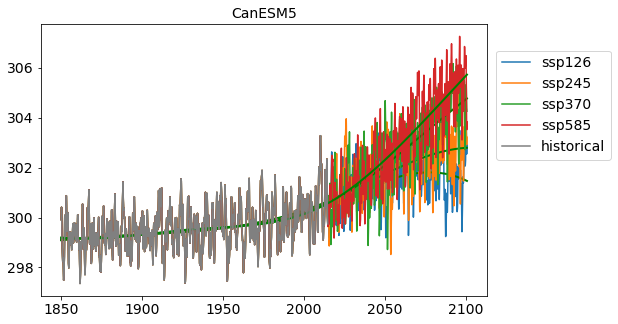

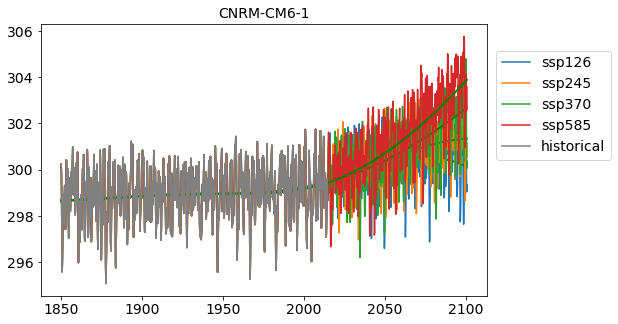

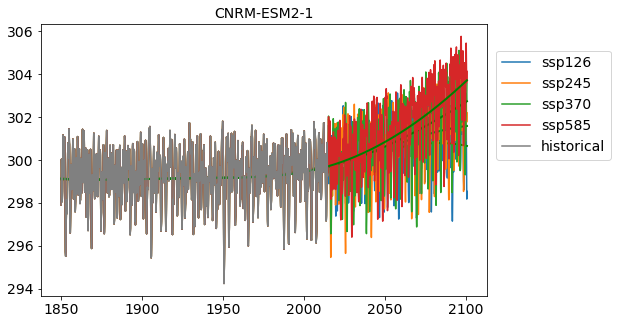

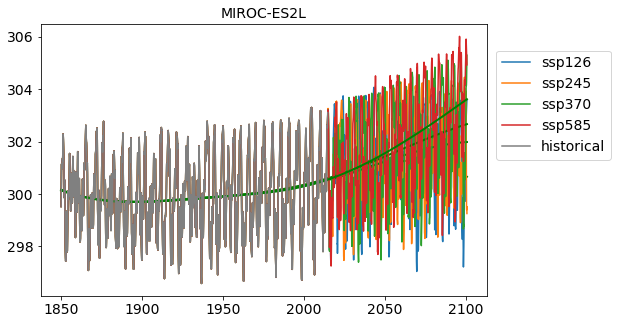

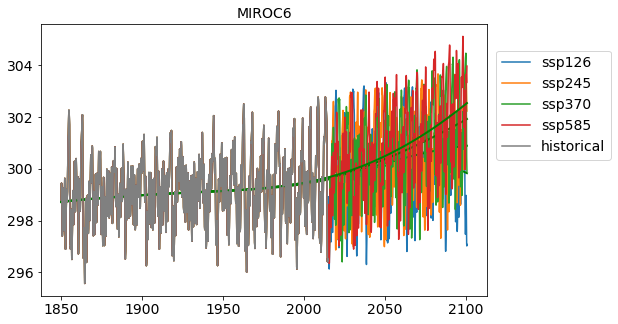

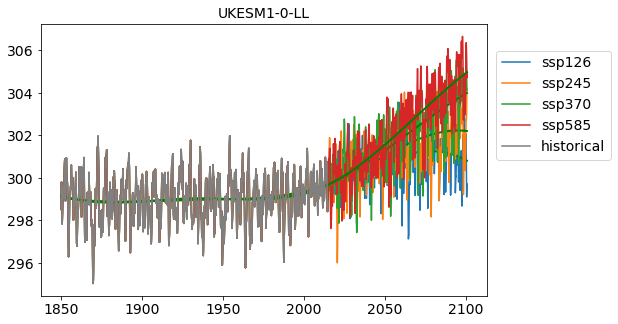

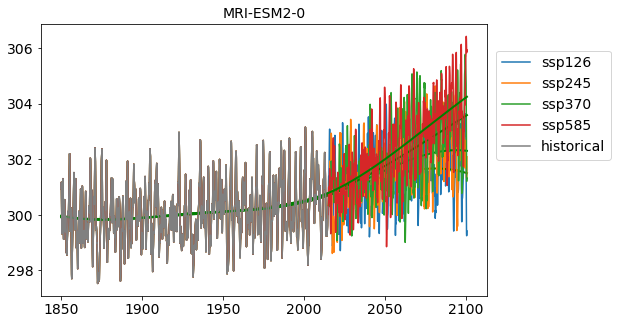

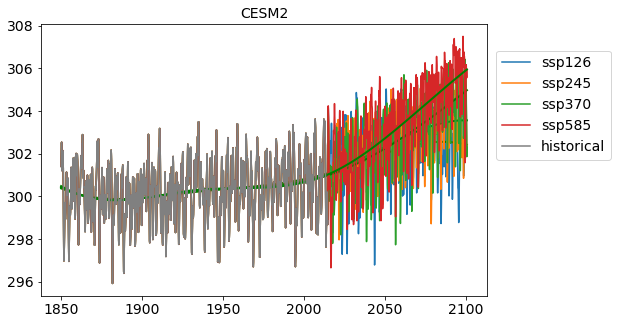

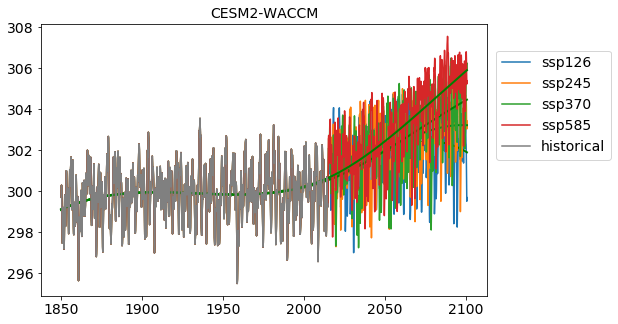

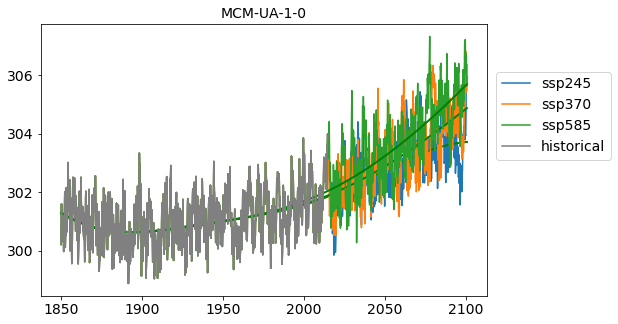

In [4]:
internal_knots = [1850 + (2014-1850)/2, 2014] # = historical midpoint (1932) and endpoint (2014)

hist_years = np.arange(1850 + 0.5/12 + 1/12, 2015-1/12, 1/12)
ssp_years = np.arange(2015+ 0.5/12, 2101-1/12, 1/12)
all_years = np.arange(1850 + 0.5/12 + 1/12, 2101-1/12, 1/12)
ssp_length = 86*12-1; # cut in year 2100. Some exp go beyond this year.

anomalies = {}

for model in models:
    anomalies[model] = {}
    fig, ax = plt.subplots(figsize = [8,5])

    hist_data = data_dict[model]['historical']
    hist_trends = {}

    # combine historical and ssp data, then smooth the combined time series
    # to minimize discontinuity of the trend between years 2014 - 2015
    for exp in data_dict[model].keys():
        if exp not in ['piControl', 'historical']:
            ssp_data = data_dict[model][exp][:ssp_length]
            # approximate missing end of historical by a mean
            exp_data = np.concatenate((hist_data, [np.mean([hist_data[-1], ssp_data[0]])], ssp_data))
            plt.plot(all_years, exp_data, label = exp) 
            spl = LSQUnivariateSpline(all_years, exp_data, internal_knots)
            ax.plot(all_years, spl(all_years), 'g', lw=2)
            
            # save ssp anomaly in dictionary
            anomalies[model][exp] = data_dict[model][exp][:ssp_length] - spl(ssp_years)
    
    ax.plot(hist_years, hist_data, color = 'gray', label = 'historical')
    ax.set_title(model, fontsize = 14)
    ax.tick_params(axis='both',labelsize=14)
    ax.legend(loc=(1.02,0.5), fontsize = 14);
    

## Define anomalies in piControl as deviation from a linear trend fit for all years available and subtract piControl climatology from all anomalies

In [5]:
control_clim = {}
for model in models:
    exp = 'piControl'
    control_data = data_dict[model][exp]
    p = np.polyfit(np.arange(len(control_data)), control_data, deg = 1)
    trend = np.polyval(p,np.arange(len(control_data)))
    anomalies[model][exp] = control_data - trend

    # then find piControl climatology:
    c_anom = np.concatenate(([np.nan],control_data - trend,[np.nan]))
    clim = np.zeros(12)
    for month in range(12):
        clim[month] = np.nanmean(c_anom[month::12])
    control_clim[model] = clim
    
    anomalies[model][exp] -= np.tile(clim,int(len(c_anom)/12))[1:-1]
    
    for exp in experiments[2:]:
        if exp in anomalies[model]:
            anomalies[model][exp] -= np.tile(clim,86)[:-1]
    

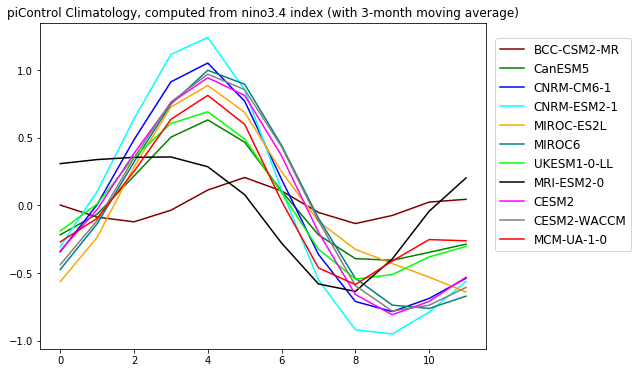

In [6]:
fig, ax = plt.subplots(figsize = [8,6])

colors = ['Maroon', 'Green', 'Blue', 'Cyan', 'Orange',  'Teal', 'Lime', 'Black', 'Magenta', 'Grey', 'Red']

for (i,model) in enumerate(models):
    ax.plot(control_clim[model], label = model, color = colors[i])
    
ax.legend(loc=(1.02,0.3), fontsize = 12)
ax.set_title('piControl Climatology, computed from nino3.4 index (with 3-month moving average)', fontsize = 12);

In [7]:
# convert to dataframe before saving:
df = None
for model in models:
    for exp in experiments:
        if exp in anomalies[model]:
            colname = [(model, exp)]
            df_col = pd.DataFrame(anomalies[model][exp], columns = colname)
            if df is None:
                df = df_col
            else:
                df = pd.merge(df, df_col, left_index=True, right_index=True, how='outer')
df.columns = pd.MultiIndex.from_tuples(df.columns, names=['Model', 'Experiment'])
#df.to_csv('../Processed_data/Nino3_4_monthly/detrended_deseasonalised_single_members.txt')
df

Model      BCC-CSM2-MR                                           CanESM5  \
Experiment   piControl    ssp126    ssp245    ssp370    ssp585 piControl   
0            -0.274695  0.559734  0.554233  0.399266  0.411986  0.951516   
1             0.092108  0.792134  0.786909  0.416502  0.476498  0.894688   
2             0.417530  0.859146  0.785561  0.371135  0.336926  0.902151   
3             0.704529  0.715388  0.677149  0.453138  0.267909  0.865105   
4             0.880683  0.456591  0.485367  0.629221  0.200070  0.670894   
...                ...       ...       ...       ...       ...       ...   
14393              NaN       NaN       NaN       NaN       NaN       NaN   
14394              NaN       NaN       NaN       NaN       NaN       NaN   
14395              NaN       NaN       NaN       NaN       NaN       NaN   
14396              NaN       NaN       NaN       NaN       NaN       NaN   
14397              NaN       NaN       NaN       NaN       NaN       NaN   

Model                                               ...     CESM2 CESM2-WACCM  \
Experiment    ssp126    ssp245    ssp370    ssp585  ...    ssp585   piControl   
0          -0.693346 -0.796988 -0.673559 -0.714865  ...  1.764571    0.254519   
1          -0.767201 -0.947160 -0.572399 -0.858984  ...  3.226925    0.421838   
2          -0.790552 -1.061348 -0.476925 -0.811935  ...  2.827339    0.698966   
3          -0.783438 -1.073696 -0.319334 -0.817433  ...  2.299730    1.019256   
4          -0.782224 -1.061981 -0.348179 -0.710542  ...  1.803424    1.344797   
...              ...       ...       ...       ...  ...       ...         ...   
14393            NaN       NaN       NaN       NaN  ...       NaN         NaN   
14394            NaN       NaN       NaN       NaN  ...       NaN         NaN   
14395            NaN       NaN       NaN       NaN  ...       NaN         NaN   
14396            NaN       NaN       NaN       NaN  ...       NaN         NaN   
14397            NaN       NaN       NaN       NaN  ...       NaN         NaN   

Model                                              MCM-UA-1-0            \
Experiment    ssp126    ssp245    ssp370    ssp585  piControl    ssp245   
0          -0.249166 -0.193694 -0.202217 -0.267643  -0.651448  1.717755   
1          -0.010794  0.107033  0.037901  0.132372  -0.660328  1.195248   
2           0.221907  0.514252  0.271238  0.512821  -0.661716  0.786149   
3           0.519607  0.773172  0.498358  0.839340  -0.663547  0.751735   
4           0.796709  1.005895  0.583532  0.998802  -0.705352  0.935811   
...              ...       ...       ...       ...        ...       ...   
14393            NaN       NaN       NaN       NaN        NaN       NaN   
14394            NaN       NaN       NaN       NaN        NaN       NaN   
14395            NaN       NaN       NaN       NaN        NaN       NaN   
14396            NaN       NaN       NaN       NaN        NaN       NaN   
14397            NaN       NaN       NaN       NaN        NaN       NaN   

Model                           
Experiment    ssp370    ssp585  
0           1.722895  1.556504  
1           1.094185  1.209621  
2           0.493311  0.920747  
3           0.253800  0.938345  
4           0.342742  1.113060  
...              ...       ...  
14393            NaN       NaN  
14394            NaN       NaN  
14395            NaN       NaN  
14396            NaN       NaN  
14397            NaN       NaN  

[14398 rows x 54 columns]

In [8]:
14398/12

1199.8333333333333

## Study anomalies:

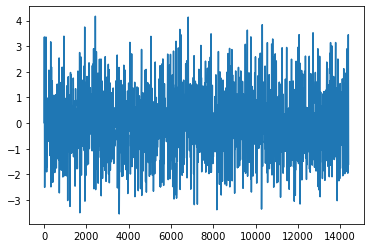

In [9]:
plt.plot(anomalies['CESM2']['piControl']);

# Compute variance for each model and experiment:

### Put results in a Figure similar to Figure 1 (Could be plot b) in Figure 1)

In [10]:
# define x-coordiates and colors for each experiment
x = {}
colors = ['black', 'blue', 'purple', 'red', 'green', 'cyan']
color_dict = {}
delta_x = 0.1
for ind,exp in enumerate(experiments):
    x[exp] = np.arange(len(models)) + 1 + delta_x*ind
    color_dict[exp] = colors[ind]

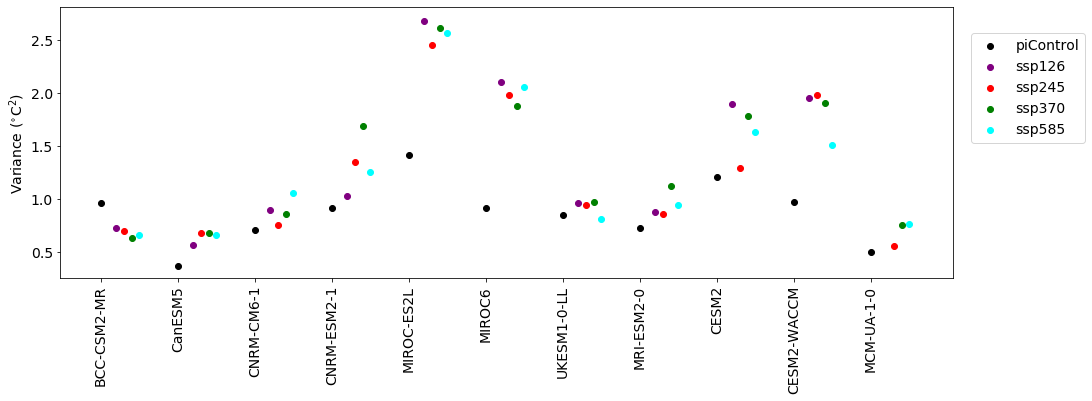

In [11]:
# create figure:
fig, ax = plt.subplots(figsize = [16,5])

for (k,model) in enumerate(models):
    for exp in experiments:
        if exp in anomalies[model]:
            anom = anomalies[model][exp]
            if k == 1:
                ax.scatter(x[exp][k], anom.var(),  marker = 'o', color=color_dict[exp], label = exp)
            else:
                ax.scatter(x[exp][k], anom.var(),  marker = 'o', color=color_dict[exp])
            
ax.tick_params(axis='both',labelsize=14)    
ax.set_ylabel('Variance ($^{\circ}$C$^2$)', fontsize = 14)
plt.xticks(x['piControl'], models, rotation=90);
ax.legend(loc=(1.02,0.5), fontsize = 14);


## Spectral analysis

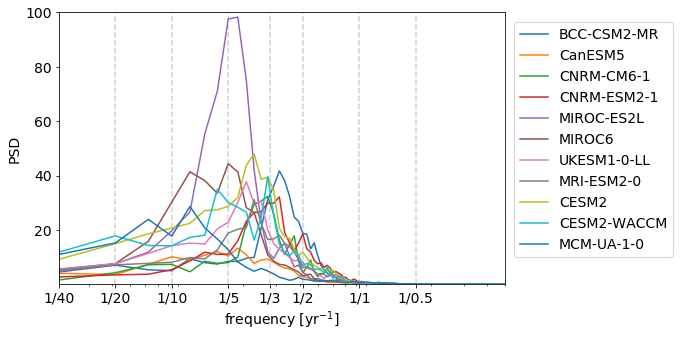

In [12]:
from scipy import signal

exp = 'piControl'

x_axis = 'frequency'
#x_axis = 'period'

fig, ax = plt.subplots(figsize = (8,5))

# plot vertical lines at given periods:
if x_axis == 'frequency':
    xcoords = [1/2, 1, 2, 3, 5, 10, 20, 40] # unit years
    for xc in xcoords:
        ax.axvline(x=1/(12*xc), color='lightgray', linestyle='--')
elif x_axis == 'period':
    #xcoords = [1/6,  1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20]
    xcoords = [1/6, 1/4, 1, 2, 3, 5, 10, 20, 40] # unit years
    for xc in xcoords:
        ax.axvline(x=(12*xc), color='lightgray', linestyle='--')
    
for model in models:
    x = anomalies[model][exp]
    f, Pxx_den = signal.welch(x, nperseg=40*12)
    if x_axis == 'frequency':
        #plt.loglog(f, Pxx_den, label = model)
        plt.semilogx(f, Pxx_den, label = model)
        plt.xticks(1/(12*np.array(xcoords)),['1/' +str(xcoords[i]) for i in range(len(xcoords))])
        plt.xlabel('frequency [yr$^{-1}$]', fontsize = 14)
        plt.xlim(1/(40*12), 1/2)
        plt.ylim(2*10**(-2), 10**2)
    elif x_axis == 'period':
        #plt.loglog(np.flip(1/f[1:]), np.flip(Pxx_den[1:]), label = model)
        plt.semilogx(np.flip(1/f[1:]), np.flip(Pxx_den[1:]), label = model)
        plt.xticks(12*np.array(xcoords), np.array(xcoords))
        plt.xlabel('Period [yrs]', fontsize = 14)
        plt.xlim(2, 12*40)
        plt.ylim(2*10**(-2), 10**2)

plt.ylabel('PSD', fontsize = 14)
ax.legend(loc=(1.02,0.1), fontsize = 14);
plt.tick_params(axis='both', labelsize = 14)

plt.show()


In [13]:
# function for plotting thick lins outside an interval:
def thick_lines(f, Pxx, min_vals, max_vals, ax, xaxis = 'period', lw = 4):
    # perform a linear interpolation to make points more dense
    f_intp = np.arange(min(f[1:]), max(f[1:]), np.diff(f)[0]/20)
    P_intp = np.interp(f_intp, f[1:], Pxx[1:])
    max_vals_intp = np.interp(f_intp, f[1:], max_vals); min_vals_intp = np.interp(f_intp, f[1:], min_vals);
    # find out where plot is outside shaded interval
    i=0;
    while i < len(f_intp):
        if P_intp[i] > max_vals_intp[i]:
            first_i = i
            # find first index not satisfying this criterion:
            while P_intp[i] > max_vals_intp[i] and i < len(f_intp)-1:
                i += 1;
            # plot thick line
            if xaxis == 'period':
                ax.semilogx(np.flip(1/f_intp[first_i:i]), np.flip(P_intp[first_i:i]), color = "black", linewidth = lw)
            elif xaxis == 'frequency':
                ax.semilogx(f_intp[first_i:i], P_intp[first_i:i], color = "black", linewidth = lw)
        elif P_intp[i] < min_vals_intp[i]:
            first_i = i
            # find first index not satisfying this criterion:
            while P_intp[i] < min_vals_intp[i] and i < len(f_intp)-1:
                i += 1;
            # plot thick line
            if xaxis == 'period':
                ax.semilogx(np.flip(1/f_intp[first_i:i]), np.flip(P_intp[first_i:i]), linewidth = lw, color = 'gray')
            elif xaxis == 'frequency':
                ax.semilogx(f_intp[first_i:i], P_intp[first_i:i], linewidth = lw, color = 'gray')
        i += 1



BCC-CSM2-MR
ssp126
ssp245
ssp370
ssp585


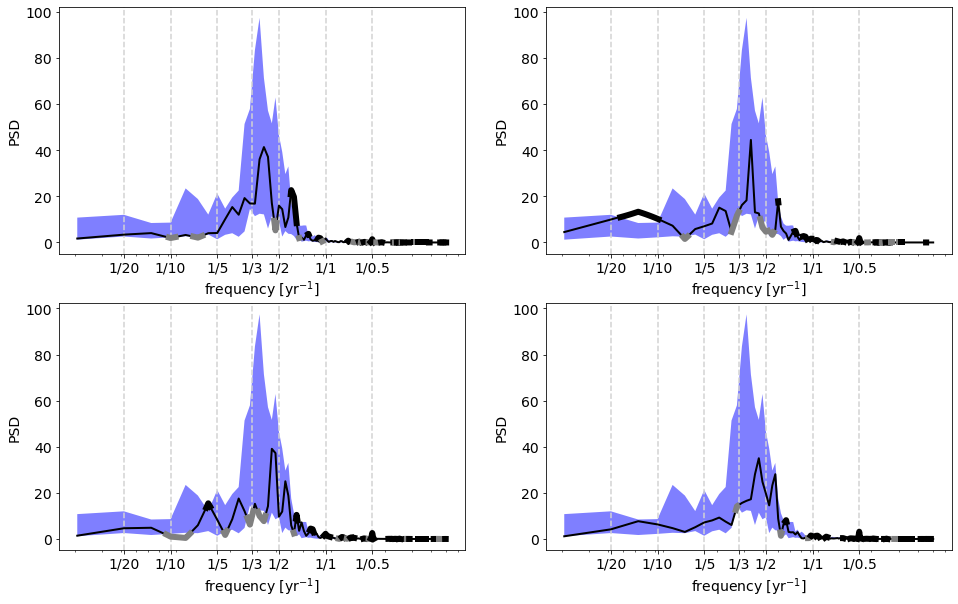

In [14]:
model = models[0]
print(model)

fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (8*2,5*2))
axes = np.concatenate(axes)
seg_length = 86*12; nperseg = 40*12
overlap = seg_length - 30*12; 

# plot vertical lines at given periods:
#xcoords = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20]
xcoords = [0.5, 1, 2, 3, 5, 10, 20]
for ax in axes:
    for xc in xcoords:
        #ax.axvline(x=12*xc, color='lightgray', linestyle='--')
        ax.axvline(x=1/(12*xc), color='lightgray', linestyle='--')

exp = 'piControl'
x = anomalies[model][exp][:500*12]
starttimes = np.arange(0,len(x)-seg_length+1,seg_length - overlap)
segment_list = np.full((len(starttimes), seg_length), np.nan)
Pxx_list = np.full((len(starttimes), int(nperseg/2)), np.nan)
for (i,k) in enumerate(starttimes):
    segment = x[k:k+seg_length]; segment_list[i] = segment
    f, Pxx = signal.welch(segment, nperseg=nperseg); Pxx_list[i] = Pxx[1:]
    
# find min and max values obtained at each frequency:
min_vals = np.zeros(int(nperseg/2)); max_vals = np.zeros(int(nperseg/2));
for (i,fi) in enumerate(f[1:]):
    Pxx_i = Pxx_list[:,i]
    min_vals[i] = Pxx_i.min()
    max_vals[i] = Pxx_i.max()
    

for ax in axes:
    #ax.fill_between(np.flip(1/f[1:]), np.flip(min_vals), np.flip(max_vals), facecolor='blue', alpha=0.5)   
    ax.fill_between(f[1:], min_vals, max_vals, facecolor='blue', alpha=0.5)       

for (k, exp) in enumerate(experiments[2:]):
    print(exp)
    #exp = 'ssp370'
    #ax = np.concatenate(axes)[i]
    ax = axes[k]
    x = anomalies[model][exp]
    f, Pxx = signal.welch(x, nperseg=nperseg);
    ax.semilogx(f[1:], Pxx[1:], color = "black", linewidth = 2)
    #ax.semilogx(np.flip(1/f[1:]), np.flip(Pxx[1:]), color = "black", linewidth = 2)
    thick_lines(f, Pxx, min_vals, max_vals, ax, lw = 6, xaxis = 'frequency')
    ax.set_xlabel('frequency [yr$^{-1}$]', fontsize = 14)
    #ax.set_xlabel('Period [yrs]', fontsize = 14)
    ax.set_ylabel('PSD', fontsize = 14)
    ax.tick_params(axis='both', labelsize = 14)

plt.setp(axes, xticks=1/(12*np.array(xcoords)), xticklabels=['1/' +str(xcoords[i]) for i in range(len(xcoords))])
#plt.xticks(12*np.array(xcoords),np.array(xcoords))

plt.show()



## Loop through all models

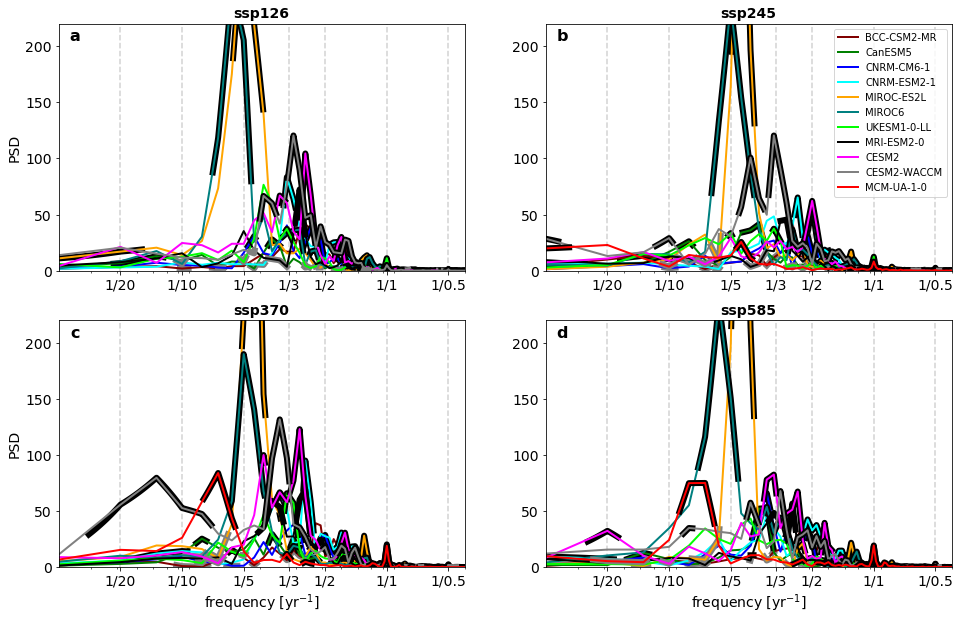

In [15]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (8*2,5*2))
axes = np.concatenate(axes)
seg_length = 86*12; nperseg = 40*12
overlap = seg_length - 30*12; 
color_list = ['Maroon', 'Green', 'Blue', 'Cyan', 'Orange',  'Teal', 'Lime', 'Black', 'Magenta', 'Grey', 'Red']
colors = {}
for (i,model) in enumerate(models):
    colors[model] = color_list[i]

# plot vertical lines at given periods:
#xcoords = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20]
xcoords = [0.5, 1, 2, 3, 5, 10, 20]
for (k,ax) in enumerate(axes):
    for xc in xcoords:
        #ax.axvline(x=12*xc, color='lightgray', linestyle='--')
        ax.axvline(x=1/(12*xc), color='lightgray', linestyle='--')
    if k in [2,3]:
        ax.set_xlabel('frequency [yr$^{-1}$]', fontsize = 14)
        #ax.set_xlabel('Period [yrs]', fontsize = 14)
    if k in [0,2]:
        ax.set_ylabel('PSD', fontsize = 14)
    ax.tick_params(axis='both', labelsize = 14)
    ax.set_ylim(0,220)
    ax.set_xlim(1/(40*12), 1/(5))

for model in models:
    exp = 'piControl'
    x = anomalies[model][exp][:500*12]
    starttimes = np.arange(0,len(x)-seg_length+1,seg_length - overlap)
    segment_list = np.full((len(starttimes), seg_length), np.nan)
    Pxx_list = np.full((len(starttimes), int(nperseg/2)), np.nan)
    for (i,k) in enumerate(starttimes):
        segment = x[k:k+seg_length]; segment_list[i] = segment
        f, Pxx = signal.welch(segment, nperseg=nperseg); Pxx_list[i] = Pxx[1:]
    
    # find min and max values obtained at each frequency:
    min_vals = np.zeros(int(nperseg/2)); max_vals = np.zeros(int(nperseg/2));
    for (i,fi) in enumerate(f[1:]):
        Pxx_i = Pxx_list[:,i]
        min_vals[i] = Pxx_i.min()
        max_vals[i] = Pxx_i.max()    

    for (k, exp) in enumerate(experiments[2:]):
        #print(exp)
        ax = axes[k]
        ax.set_title(exp, fontsize = 14, fontweight = 'bold')
        if exp in anomalies[model]:
            x = anomalies[model][exp]
            f, Pxx = signal.welch(x, nperseg=nperseg);
            thick_lines(f, Pxx, min_vals, max_vals, ax, lw = 6, xaxis = 'frequency')
            if k==1:
                ax.semilogx(f[1:], Pxx[1:], linewidth = 2, label = model, color = colors[model])
            else:
                ax.semilogx(f[1:], Pxx[1:], linewidth = 2, color = colors[model])
            #ax.semilogx(np.flip(1/f[1:]), np.flip(Pxx[1:]), color = "black", linewidth = 2)
            

plt.setp(axes, xticks=1/(12*np.array(xcoords)), xticklabels=['1/' +str(xcoords[i]) for i in range(len(xcoords))])
#plt.xticks(12*np.array(xcoords),np.array(xcoords))

axes[1].legend(loc = 1)

panels = ['a', 'b', 'c', 'd']
for (i,panel) in enumerate(panels):
    axes[i].text(0.04, 0.95, panel, fontweight = 'bold', fontsize = 16, horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes);

plt.show()



## Separate plots for each model:

BCC-CSM2-MR


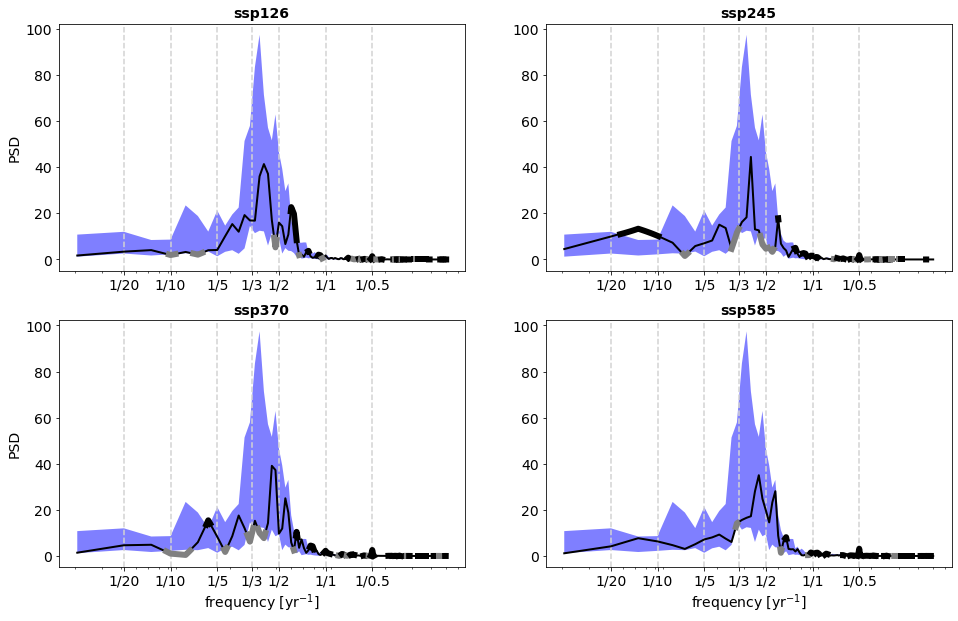

CanESM5


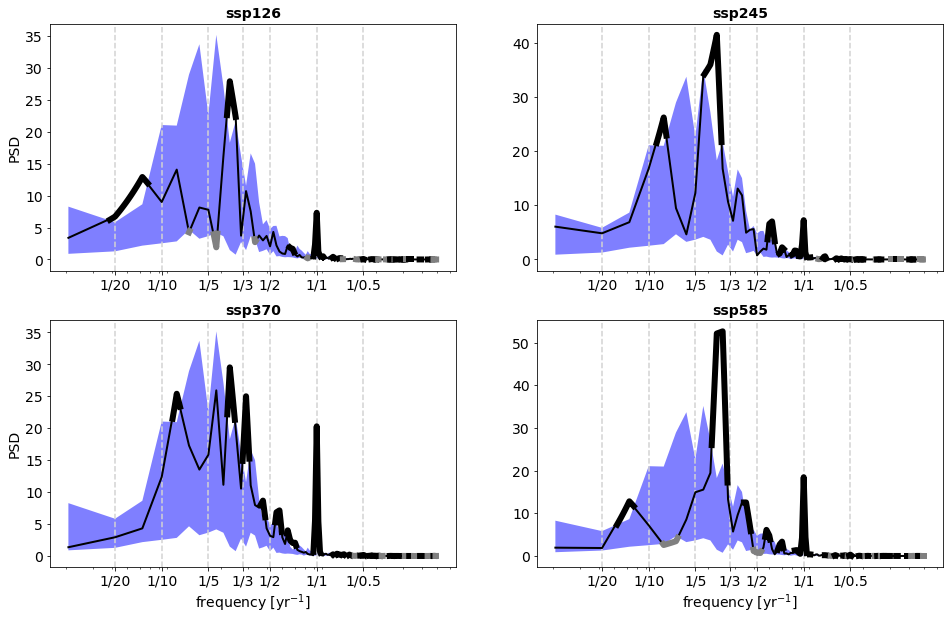

CNRM-CM6-1


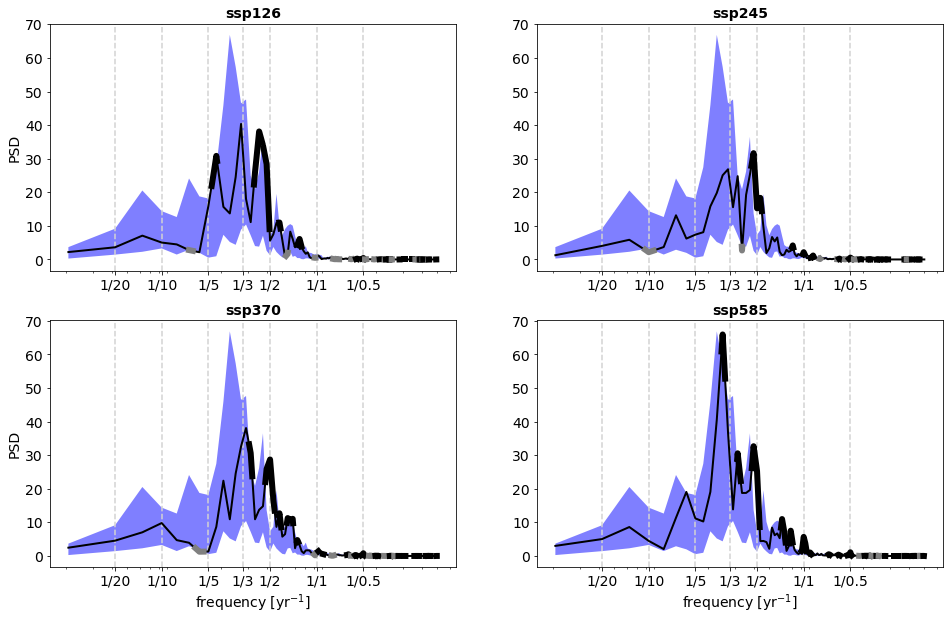

CNRM-ESM2-1


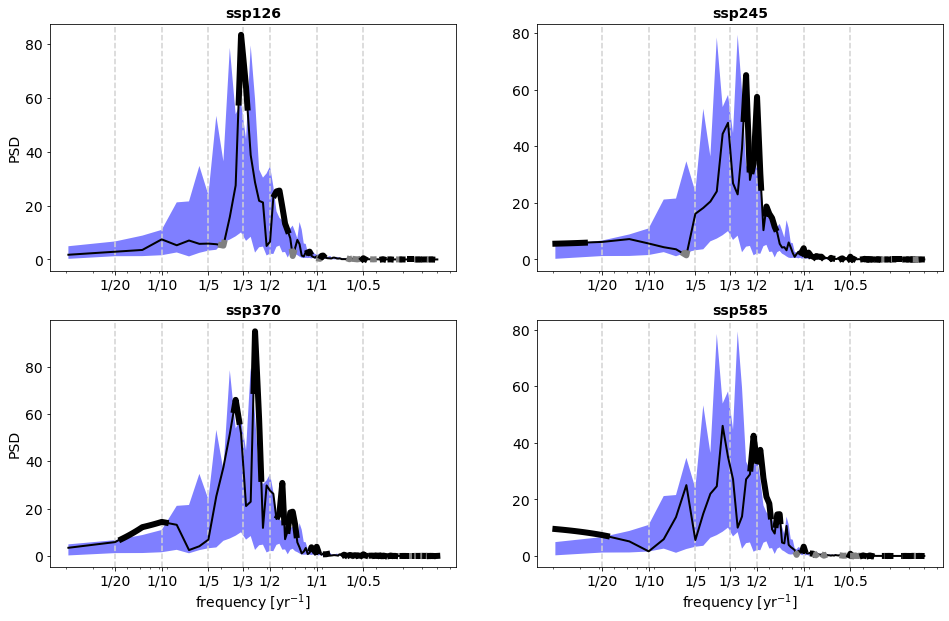

MIROC-ES2L


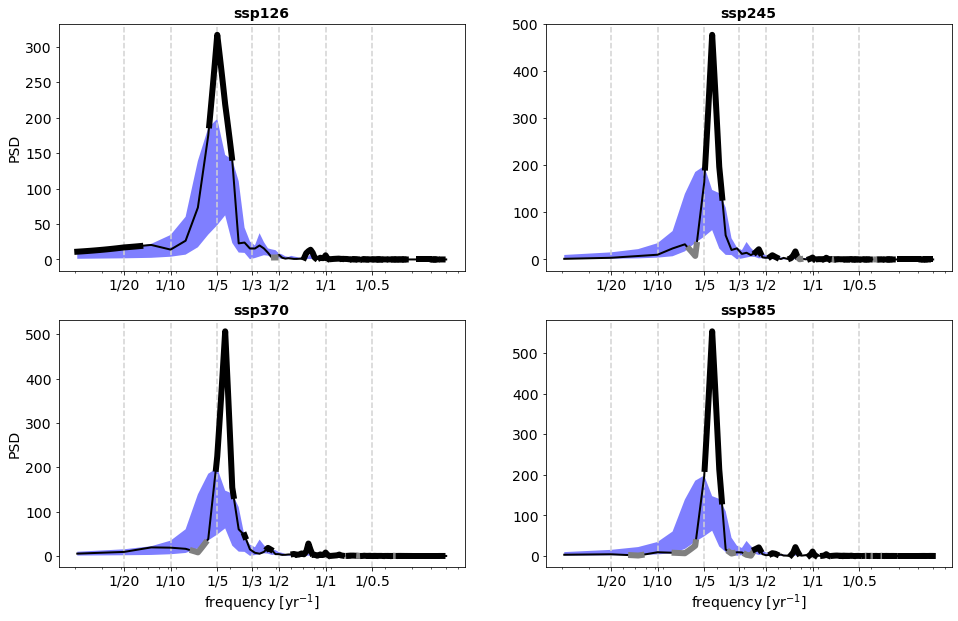

MIROC6


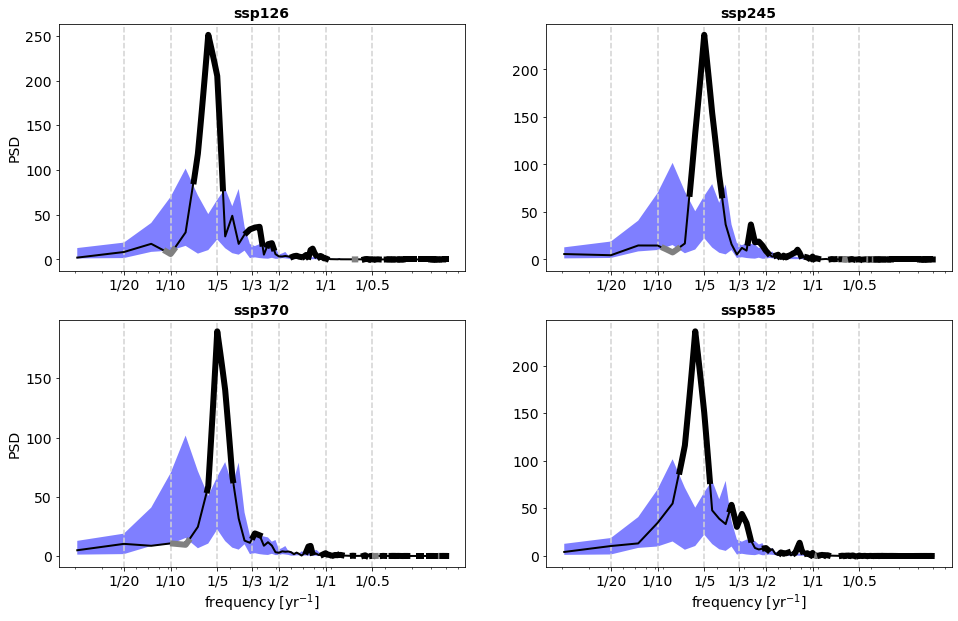

UKESM1-0-LL


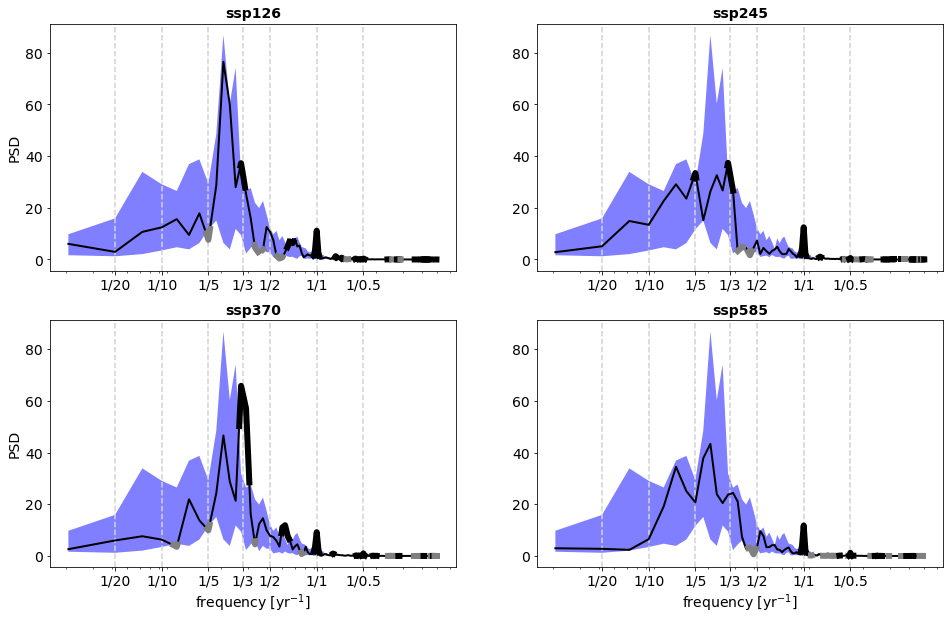

MRI-ESM2-0


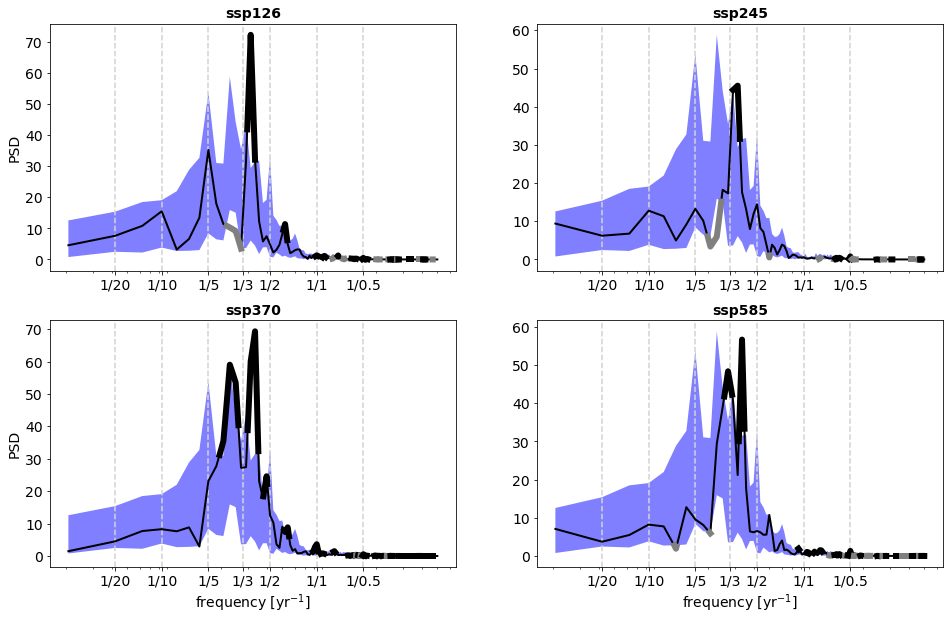

CESM2


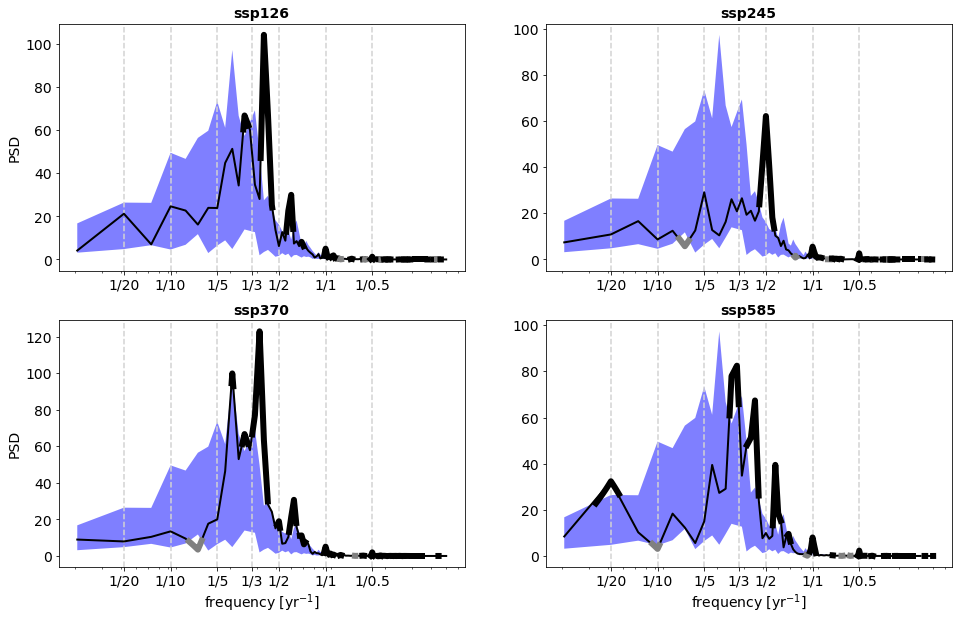

CESM2-WACCM


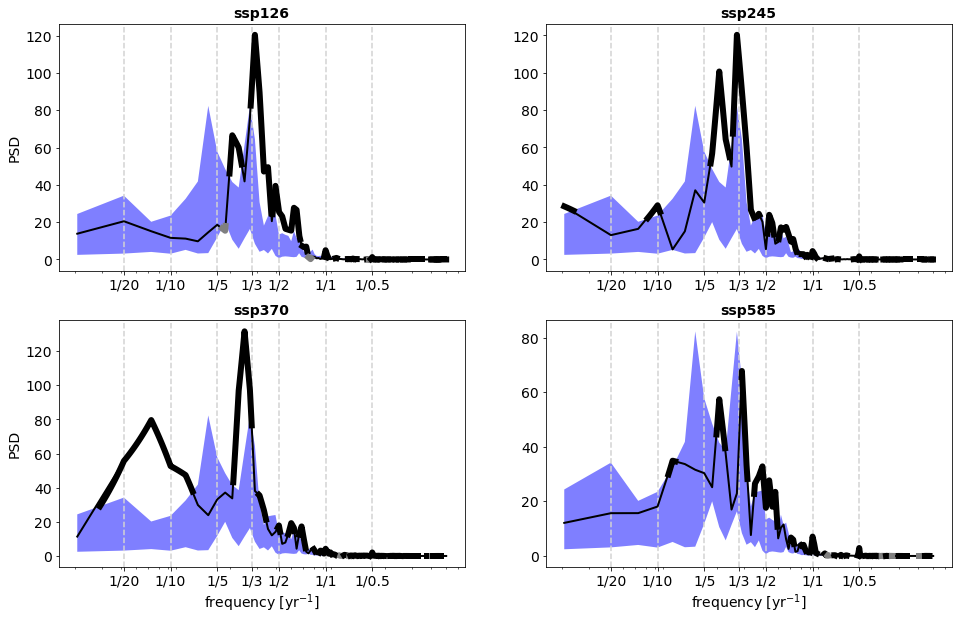

MCM-UA-1-0


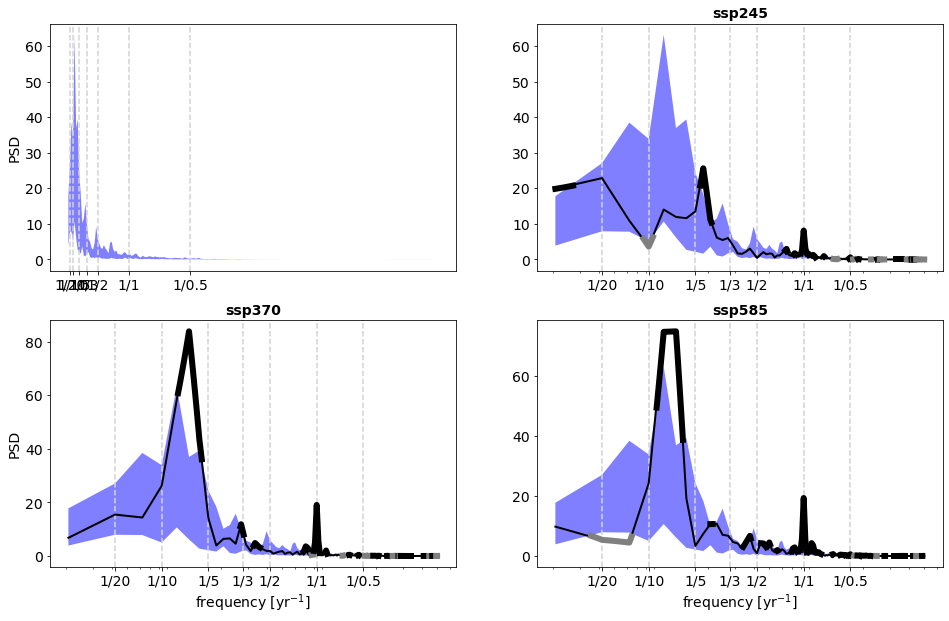

In [16]:
for model in models:
    print(model)

    fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (8*2,5*2))
    axes = np.concatenate(axes)
    seg_length = 86*12; nperseg = 40*12
    overlap = seg_length - 30*12; 

    # plot vertical lines at given periods:
    #xcoords = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20]
    xcoords = [0.5, 1, 2, 3, 5, 10, 20]
    for (k,ax) in enumerate(axes):
        for xc in xcoords:
            #ax.axvline(x=12*xc, color='lightgray', linestyle='--')
            ax.axvline(x=1/(12*xc), color='lightgray', linestyle='--')
        if k in [2,3]:
            ax.set_xlabel('frequency [yr$^{-1}$]', fontsize = 14)
            #ax.set_xlabel('Period [yrs]', fontsize = 14)
        if k in [0,2]:
            ax.set_ylabel('PSD', fontsize = 14)
        ax.tick_params(axis='both', labelsize = 14)
        #ax.set_ylim(0,220)
        #ax.set_xlim(1/(40*12), 1/(5))

    exp = 'piControl'
    x = anomalies[model][exp][:500*12]
    starttimes = np.arange(0,len(x)-seg_length+1,seg_length - overlap)
    segment_list = np.full((len(starttimes), seg_length), np.nan)
    Pxx_list = np.full((len(starttimes), int(nperseg/2)), np.nan)
    for (i,k) in enumerate(starttimes):
        segment = x[k:k+seg_length]; segment_list[i] = segment
        f, Pxx = signal.welch(segment, nperseg=nperseg); Pxx_list[i] = Pxx[1:]

    # find min and max values obtained at each frequency:
    min_vals = np.zeros(int(nperseg/2)); max_vals = np.zeros(int(nperseg/2));
    for (i,fi) in enumerate(f[1:]):
        Pxx_i = Pxx_list[:,i]
        min_vals[i] = Pxx_i.min()
        max_vals[i] = Pxx_i.max()


    for ax in axes:
        #ax.fill_between(np.flip(1/f[1:]), np.flip(min_vals), np.flip(max_vals), facecolor='blue', alpha=0.5)   
        ax.fill_between(f[1:], min_vals, max_vals, facecolor='blue', alpha=0.5)       

    for (k, exp) in enumerate(experiments[2:]):
        ax = axes[k]
        if exp in anomalies[model]:
            x = anomalies[model][exp]
            f, Pxx = signal.welch(x, nperseg=nperseg);
            ax.set_title(exp, fontsize = 14, fontweight = 'bold')
            ax.semilogx(f[1:], Pxx[1:], color = "black", linewidth = 2)
            #ax.semilogx(np.flip(1/f[1:]), np.flip(Pxx[1:]), color = "black", linewidth = 2)
            thick_lines(f, Pxx, min_vals, max_vals, ax, lw = 6, xaxis = 'frequency')

    plt.setp(axes, xticks=1/(12*np.array(xcoords)), xticklabels=['1/' +str(xcoords[i]) for i in range(len(xcoords))])
    #plt.xticks(12*np.array(xcoords),np.array(xcoords))

    plt.show()

